In [76]:
# !pip install yfinance

import yfinance as yf

def fetch_stock_data(ticker_symbol):
    stock = yf.Ticker(ticker_symbol)
    data = stock.history(period="2y")
    return data['Close']

stock_data = fetch_stock_data("AAPL")

In [77]:
stock_data

Date
2021-09-28 00:00:00-04:00    140.286987
2021-09-29 00:00:00-04:00    141.196457
2021-09-30 00:00:00-04:00    139.881683
2021-10-01 00:00:00-04:00    141.018524
2021-10-04 00:00:00-04:00    137.548645
                                ...    
2023-09-22 00:00:00-04:00    174.789993
2023-09-25 00:00:00-04:00    176.080002
2023-09-26 00:00:00-04:00    171.960007
2023-09-27 00:00:00-04:00    170.429993
2023-09-28 00:00:00-04:00    171.580002
Name: Close, Length: 504, dtype: float64

In [78]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def preprocess_data_for_cgan(stock_data):
    """
    Preprocesses stock data for Conditional GAN input.

    Args:
    - stock_data (pd.Series): Raw stock closing prices over a period of time.

    Returns:
    - scaled_stock_data (pd.Series): MinMax scaled stock data.
    - scaled_volatilities (pd.Series): MinMax scaled rolling volatilities.
    - scaler (MinMaxScaler): The scaler object used, for potential inverse transformations later.
    """

    # Initialize two MinMaxScalers (one for stock data and another for volatilities)
    stock_scaler = MinMaxScaler()
    volatility_scaler = MinMaxScaler()

    # Fit the stock_scaler to the stock_data
    stock_scaler.fit(stock_data.values.reshape(-1, 1))

    # Transform the stock_data using the fitted stock_scaler
    scaled_stock_data_array = stock_scaler.transform(stock_data.values.reshape(-1, 1))
    scaled_stock_data = pd.Series(scaled_stock_data_array.flatten(), index=stock_data.index)

    # Compute the rolling volatilities
    volatilities = stock_data.rolling(window=5).std().dropna()

    # Adjust scaled_stock_data to match the length and index of volatilities
    scaled_stock_data = scaled_stock_data[len(scaled_stock_data) - len(volatilities):]
    scaled_stock_data.index = volatilities.index

    # Fit the volatility_scaler to the volatilities
    volatility_scaler.fit(volatilities.values.reshape(-1, 1))

    # Transform the computed volatilities using the fitted volatility_scaler
    scaled_volatilities_array = volatility_scaler.transform(volatilities.values.reshape(-1, 1))
    scaled_volatilities = pd.Series(scaled_volatilities_array.flatten(), index=volatilities.index)

    return scaled_stock_data, scaled_volatilities, stock_scaler

In [65]:
import tensorflow as tf
import time
import numpy as np

# Constants & Hyperparameters
batch_size = 32
data_dim = 1  # We set this to 1 for 1D stock data
noise_dim = 100  # Increased the noise dimensionality
num_conditions = 1

gen_in_channels = noise_dim + num_conditions
disc_in_channels = data_dim + num_conditions

# Weight Initialization
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

# Generator Model
def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(gen_in_channels,), kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer),
        tf.keras.layers.Dense(data_dim, activation='linear', kernel_initializer=initializer)
    ])
    return model

generator = make_generator_model()

# Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(disc_in_channels,), kernel_initializer=initializer),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
        tf.keras.layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

# Losses and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Modifying learning rate to 2e-4 as per the suggestions
lr_schedule_gen = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4,
    decay_steps=10000,
    decay_rate=0.9)

lr_schedule_disc = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4,
    decay_steps=10000,
    decay_rate=0.9)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_gen)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_disc)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [66]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               52224     
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_19 (Dropout)        (None, 256)              

In [67]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 512)               1536      
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 256)               131328    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 64)               

In [68]:
import pandas as pd
scaled_stock_data, scaled_volatilities, scalar = preprocess_data_for_cgan(stock_data)

num_batches = len(scaled_stock_data) // batch_size
scaled_stock_data = scaled_stock_data[:num_batches * batch_size]
scaled_volatilities = scaled_volatilities[:num_batches * batch_size]

# Formulate the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_stock_data.values, scaled_volatilities.values)).batch(batch_size)

In [69]:
def temporal_difference(series):
    return series[1:] - series[:-1]

def generator_loss(fake_output, synthetic_data, real_data):
    main_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    synthetic_diff = temporal_difference(synthetic_data)
    real_diff = temporal_difference(real_data)

    temporal_loss = tf.reduce_mean(tf.square(synthetic_diff - real_diff))
    mse_loss = tf.reduce_mean(tf.square(synthetic_data[:-1] - synthetic_data[1:]))
    data_variance_loss = tf.reduce_mean(tf.square(tf.math.reduce_variance(synthetic_data) - tf.math.reduce_variance(real_data)))

    return main_loss + 0.1 * mse_loss + 0.1 * data_variance_loss + 0.1 * temporal_loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def train_step(data):
    real_series, volatilities = data
    real_series = tf.cast(real_series, tf.float32)
    volatilities = tf.cast(volatilities, tf.float32)
    noise = tf.random.normal([batch_size, noise_dim])
    noise_with_volatilities = tf.concat([noise, tf.reshape(volatilities, (-1, 1))], axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_series = generator(noise_with_volatilities, training=True)
        fake_series_and_volatilities = tf.concat([fake_series, tf.reshape(volatilities, (-1, 1))], axis=1)

        real_series_reshaped = tf.reshape(real_series, (-1, 1))
        real_series_and_volatilities = tf.concat([real_series_reshaped, tf.reshape(volatilities, (-1, 1))], axis=1)

        real_output = discriminator(real_series_and_volatilities, training=True)
        fake_output = discriminator(fake_series_and_volatilities, training=True)

        # Adjust the generator loss function call
        gen_loss = generator_loss(fake_output, fake_series, real_series) # Passed the real_series here
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()
        epoch_gen_losses = []
        epoch_disc_losses = []

        for data_batch in dataset:
            g_loss, d_loss = train_step(data_batch)
            epoch_gen_losses.append(g_loss.numpy())
            epoch_disc_losses.append(d_loss.numpy())

        avg_gen_loss = sum(epoch_gen_losses) / len(epoch_gen_losses)
        avg_disc_loss = sum(epoch_disc_losses) / len(epoch_disc_losses)

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print ('Epoch {}: Generator Loss: {}, Discriminator Loss: {}. Time: {} sec'.format(
            epoch+1, avg_gen_loss, avg_disc_loss, time.time()-start))

    return gen_losses, disc_losses

Epoch 1: Generator Loss: 0.6943912108739217, Discriminator Loss: 1.3859985748926797. Time: 5.680191516876221 sec
Epoch 2: Generator Loss: 0.6952492515246074, Discriminator Loss: 1.3829305330912272. Time: 0.2922646999359131 sec
Epoch 3: Generator Loss: 0.7002303759256999, Discriminator Loss: 1.363148824373881. Time: 0.26604533195495605 sec
Epoch 4: Generator Loss: 0.7108323017756144, Discriminator Loss: 1.2975598017374674. Time: 0.2545619010925293 sec
Epoch 5: Generator Loss: 0.7125421762466431, Discriminator Loss: 1.2306109507878622. Time: 0.2511725425720215 sec
Epoch 6: Generator Loss: 0.7485425035158794, Discriminator Loss: 1.35040180683136. Time: 0.24391984939575195 sec
Epoch 7: Generator Loss: 0.8302254517873128, Discriminator Loss: 1.4946828524271647. Time: 0.23124265670776367 sec
Epoch 8: Generator Loss: 0.8880977710088094, Discriminator Loss: 1.4229058424631755. Time: 0.21350932121276855 sec
Epoch 9: Generator Loss: 0.8284571528434753, Discriminator Loss: 1.39067223072052. Time:

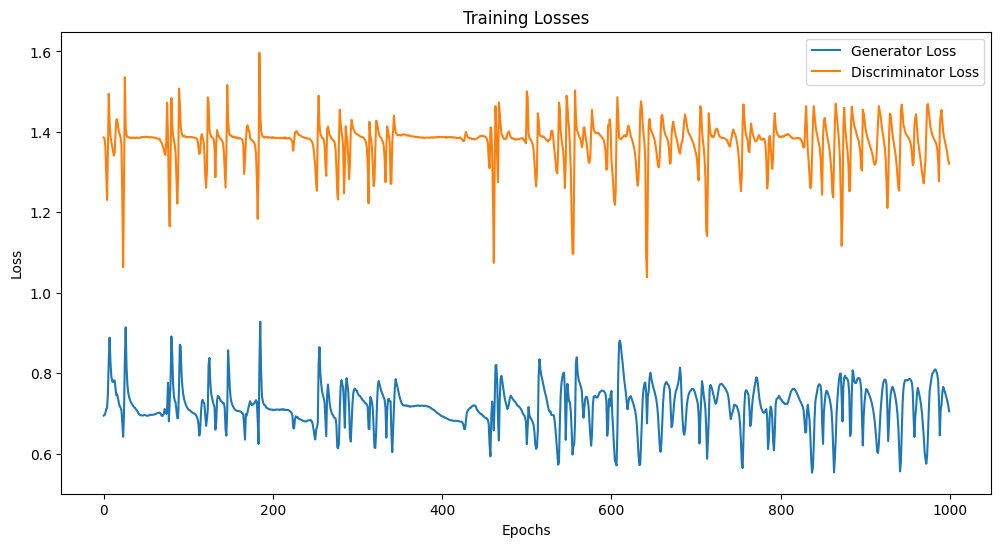

In [70]:
import time
import matplotlib.pyplot as plt

def plot_training_graphs(gen_losses, disc_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Start Training
gen_losses, disc_losses = train(train_dataset, epochs=1000)
plot_training_graphs(gen_losses, disc_losses)

In [71]:
def generate_synthetic_stock_data(generator, volatilities, num_samples):
    noise = tf.random.normal([num_samples, noise_dim], dtype=tf.float32)  # Ensure float32
    volatilities = tf.cast(volatilities, tf.float32)  # Convert to float32 if not already
    noise_with_volatilities = tf.concat([noise, tf.reshape(volatilities, (-1, 1))], axis=1)

    synthetic_data = generator(noise_with_volatilities, training=False)  # Use the generator in inference mode
    return synthetic_data

In [72]:
# Generate Synthetic Data
num_samples = len(scaled_stock_data)
synthetic_data = generate_synthetic_stock_data(generator, scaled_volatilities[:num_samples], num_samples)

def postprocess_synthetic_data(synthetic_data, scaler, original_data):
    """
    Postprocesses the synthetic stock data to match the format of the original data.

    Args:
    - synthetic_data (tf.Tensor or np.array): The synthetic stock data.
    - scaler (MinMaxScaler): The scaler object used in preprocessing.
    - original_data (pd.Series): The original stock data series.

    Returns:
    - rescaled_synthetic_data (pd.Series): The synthetic stock data in the format of the original data.
    """
    # Convert the synthetic data tensor to numpy array if it's not already
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    # Rescale the synthetic data to the original scale
    rescaled_synthetic_data_array = scaler.inverse_transform(synthetic_data)

    # Convert to a pandas series with the original data's index
    rescaled_synthetic_data = pd.Series(rescaled_synthetic_data_array.flatten(), index=original_data.index[-len(rescaled_synthetic_data_array):])

    return rescaled_synthetic_data

# Get the postprocessed synthetic data
rescaled_synthetic_data = postprocess_synthetic_data(synthetic_data, scalar, stock_data)
print(rescaled_synthetic_data)

Date
2021-11-01 00:00:00-04:00    142.932404
2021-11-02 00:00:00-04:00    137.196915
2021-11-03 00:00:00-04:00    146.628983
2021-11-04 00:00:00-04:00    140.415100
2021-11-05 00:00:00-04:00    139.839737
                                ...    
2023-09-22 00:00:00-04:00    134.010574
2023-09-25 00:00:00-04:00    130.997864
2023-09-26 00:00:00-04:00    139.510468
2023-09-27 00:00:00-04:00    154.290695
2023-09-28 00:00:00-04:00    148.403671
Length: 480, dtype: float32


In [73]:
import pandas as pd
import numpy as np

def smooth_series(series, window_size=5):
    return series.rolling(window_size).mean().dropna()

rescaled_synthetic_data_smoothed = smooth_series(rescaled_synthetic_data)

rolling_volatility = stock_data.rolling(window=5).std()
aligned_rolling_volatility = rolling_volatility[-len(rescaled_synthetic_data_smoothed):]

# Capture the residual trends of the original data
residual_trends = stock_data - smooth_series(stock_data)

# Align the length of the residuals with the synthetic data
aligned_residual_trends = residual_trends[-len(rescaled_synthetic_data_smoothed):]

# Dynamic volatility scaling based on correlation
correlation = np.corrcoef(aligned_rolling_volatility, rescaled_synthetic_data_smoothed)[0, 1]
volatility_scale = 1.5 if correlation < 0.5 else 1.0  # Adjust based on your requirements

# Identify the top 15% of days where the original stock had the highest volatility
top_volatile_days = aligned_rolling_volatility.nlargest(int(0.15 * len(aligned_rolling_volatility))).index

filtered_volatile_days = []
for day in sorted(top_volatile_days):
    if not filtered_volatile_days or (day - filtered_volatile_days[-1]).days > 1:
        filtered_volatile_days.append(day)

for day in filtered_volatile_days:
    aligned_rolling_volatility.loc[day] *= 2

# Merge the synthetic data, the scaled volatility, and the residual trends
rescaled_synthetic_data_volatile = rescaled_synthetic_data_smoothed + (aligned_rolling_volatility * volatility_scale) + aligned_residual_trends

print(rescaled_synthetic_data_volatile)

common_data = pd.concat([rescaled_synthetic_data_volatile, stock_data], axis=1, join='inner', keys=['synthetic', 'original'])
aligned_rescaled_synthetic_data_volatile = common_data['synthetic']
aligned_stock_data = common_data['original']

assert len(aligned_rescaled_synthetic_data_volatile) == len(aligned_stock_data), "The lengths are not the same."

Date
2021-11-05 00:00:00-04:00    143.924068
2021-11-08 00:00:00-05:00    141.792125
2021-11-09 00:00:00-05:00    143.730734
2021-11-10 00:00:00-05:00    140.910503
2021-11-11 00:00:00-05:00    142.388393
                                ...    
2023-09-22 00:00:00-04:00    142.948453
2023-09-25 00:00:00-04:00    142.986458
2023-09-26 00:00:00-04:00    138.276671
2023-09-27 00:00:00-04:00    140.848756
2023-09-28 00:00:00-04:00    143.478479
Length: 476, dtype: float64


In [74]:
aligned_rescaled_synthetic_data_volatile

Date
2021-11-05 00:00:00-04:00    143.924068
2021-11-08 00:00:00-05:00    141.792125
2021-11-09 00:00:00-05:00    143.730734
2021-11-10 00:00:00-05:00    140.910503
2021-11-11 00:00:00-05:00    142.388393
                                ...    
2023-09-22 00:00:00-04:00    142.948453
2023-09-25 00:00:00-04:00    142.986458
2023-09-26 00:00:00-04:00    138.276671
2023-09-27 00:00:00-04:00    140.848756
2023-09-28 00:00:00-04:00    143.478479
Name: synthetic, Length: 476, dtype: float64

In [75]:
aligned_stock_data

Date
2021-11-05 00:00:00-04:00    149.768097
2021-11-08 00:00:00-05:00    148.936493
2021-11-09 00:00:00-05:00    149.302780
2021-11-10 00:00:00-05:00    146.441666
2021-11-11 00:00:00-05:00    146.392166
                                ...    
2023-09-22 00:00:00-04:00    174.789993
2023-09-25 00:00:00-04:00    176.080002
2023-09-26 00:00:00-04:00    171.960007
2023-09-27 00:00:00-04:00    170.429993
2023-09-28 00:00:00-04:00    171.360001
Name: original, Length: 476, dtype: float64

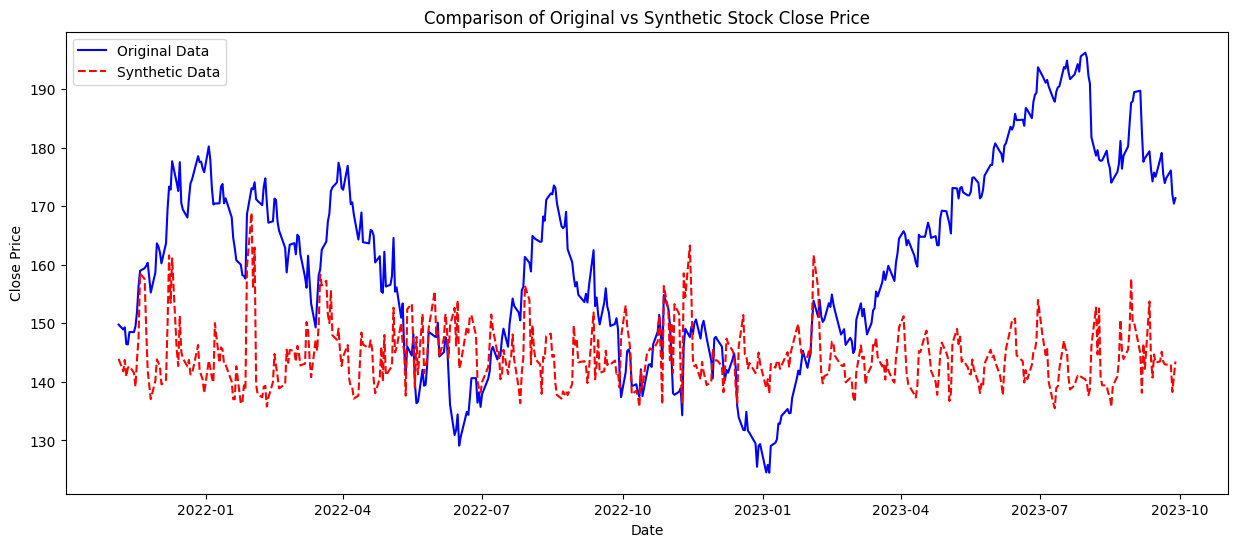

      Original Data  Synthetic Data
mean     160.193876      144.280733
std       16.305588        5.095864
25%      147.644524      140.729391
50%      160.272049      143.612877
75%      172.905369      146.441338


<ipython-input-79-541ca1427332>:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(aligned_stock_data.values, label='Original Data', shade=True)
<ipython-input-79-541ca1427332>:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(aligned_rescaled_synthetic_data_volatile.values, label='Synthetic Data', shade=True)


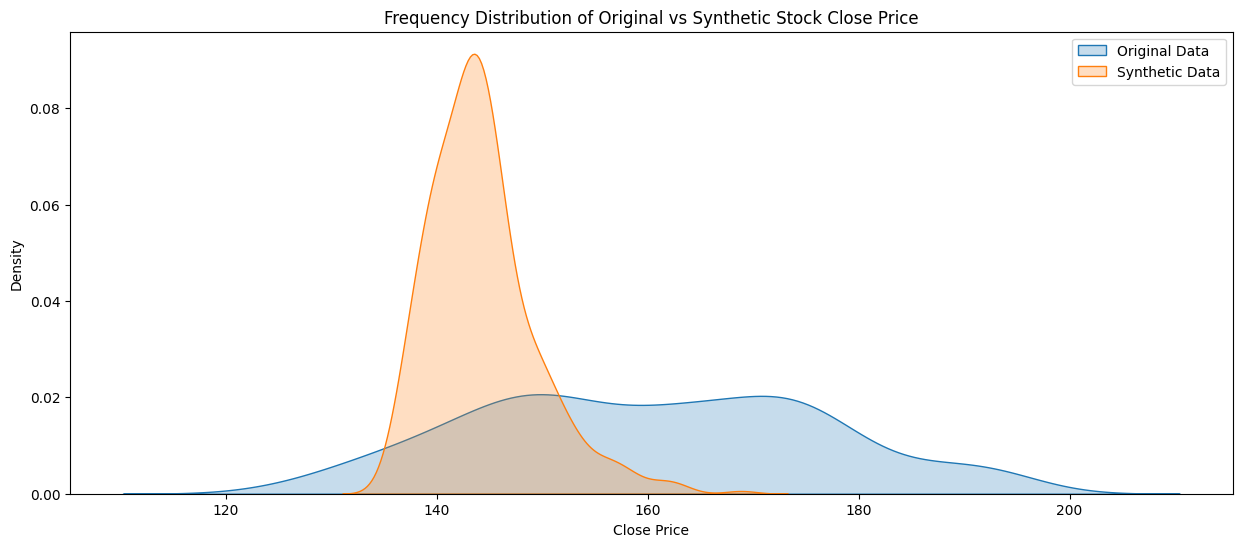

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Extract date from the index
aligned_stock_date = aligned_stock_data.index
aligned_synthetic_date = aligned_rescaled_synthetic_data_volatile.index

# 1. Visualization
plt.figure(figsize=(15, 6))
plt.plot(aligned_stock_date, aligned_stock_data.values, label='Original Data', color='blue')
plt.plot(aligned_synthetic_date, aligned_rescaled_synthetic_data_volatile.values, label='Synthetic Data', color='red', linestyle='dashed')
plt.title('Comparison of Original vs Synthetic Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 2. Statistical Properties
original_properties = {
    'mean': aligned_stock_data.mean(),
    'std': aligned_stock_data.std(),
    '25%': aligned_stock_data.quantile(0.25),
    '50%': aligned_stock_data.quantile(0.50),
    '75%': aligned_stock_data.quantile(0.75)
}

synthetic_properties = {
    'mean': aligned_rescaled_synthetic_data_volatile.mean(),
    'std': aligned_rescaled_synthetic_data_volatile.std(),
    '25%': aligned_rescaled_synthetic_data_volatile.quantile(0.25),
    '50%': aligned_rescaled_synthetic_data_volatile.quantile(0.50),
    '75%': aligned_rescaled_synthetic_data_volatile.quantile(0.75)
}

properties_df = pd.DataFrame({'Original Data': original_properties, 'Synthetic Data': synthetic_properties})
print(properties_df)

# 3. Frequency Distribution
plt.figure(figsize=(15, 6))
sns.kdeplot(aligned_stock_data.values, label='Original Data', shade=True)
sns.kdeplot(aligned_rescaled_synthetic_data_volatile.values, label='Synthetic Data', shade=True)
plt.title('Frequency Distribution of Original vs Synthetic Stock Close Price')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.legend()
plt.show()


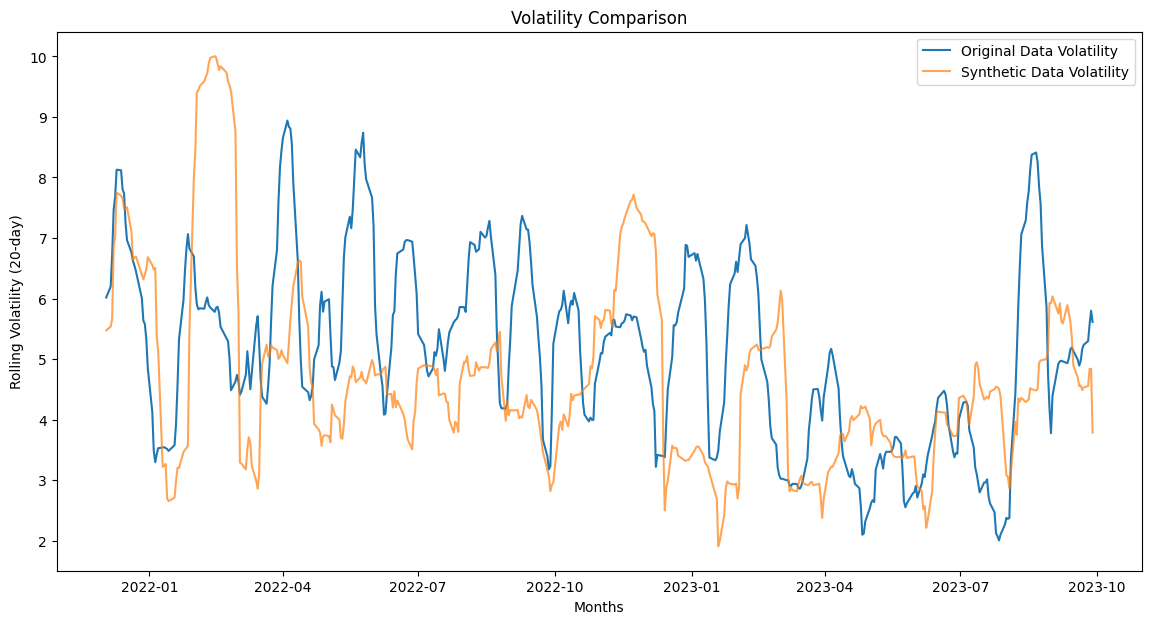

Original Volatility - Descriptive Statistics:
count    457.000000
mean       5.108452
std        1.542612
min        2.004698
25%        3.933154
50%        5.113904
75%        6.091793
max        8.940369
Name: original, dtype: float64

Synthetic Volatility - Descriptive Statistics:
count    457.000000
mean       4.678331
std        1.574341
min        1.907860
25%        3.613490
50%        4.395344
75%        5.185206
max       10.003192
Name: synthetic, dtype: float64


In [80]:
#volatility analysis
window = 20  # Using a 20-day rolling window for monthly volatility
original_volatility = aligned_stock_data.rolling(window=window).std()
synthetic_volatility = aligned_rescaled_synthetic_data_volatile.rolling(window=window).std()

plt.figure(figsize=(14, 7))
plt.plot(original_volatility, label='Original Data Volatility')
plt.plot(synthetic_volatility, label='Synthetic Data Volatility', alpha=0.7)
plt.title('Volatility Comparison')
plt.xlabel('Months')  # x-axis label
plt.ylabel('Rolling Volatility (20-day)')  # y-axis label
plt.legend()
plt.show()

print("Original Volatility - Descriptive Statistics:")
print(original_volatility.describe())

print("\nSynthetic Volatility - Descriptive Statistics:")
print(synthetic_volatility.describe())


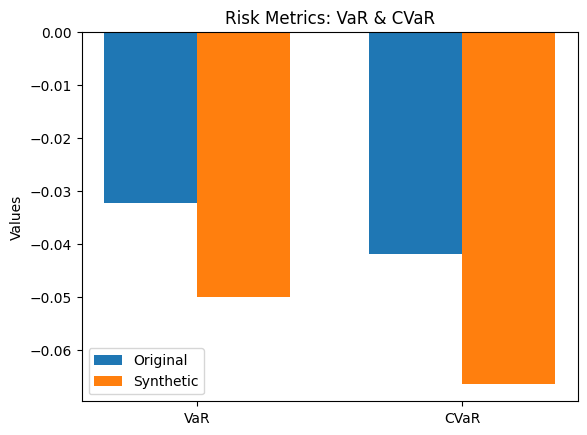

Original Data Metrics:
VaR: -0.03224
CVaR: -0.04194

Synthetic Data Metrics:
VaR: -0.05004
CVaR: -0.06633


In [81]:
#Risk Metric Analysis
import numpy as np
import matplotlib.pyplot as plt

# Calculate daily returns
original_returns = aligned_stock_data.pct_change().dropna()
synthetic_returns = aligned_rescaled_synthetic_data_volatile.pct_change().dropna()

# VaR and CVaR function
def compute_var_cvar(returns, alpha=0.05):
    """
    Compute VaR and CVaR for given returns and alpha.
    """
    sorted_returns = returns.sort_values()
    index = int(alpha * len(sorted_returns))
    VaR = sorted_returns.iloc[index]
    CVaR = sorted_returns.iloc[:index].mean()
    return VaR, CVaR

# Compute metrics
original_var, original_cvar = compute_var_cvar(original_returns)
synthetic_var, synthetic_cvar = compute_var_cvar(synthetic_returns)

# Visualization
labels = ['VaR', 'CVaR']
original_metrics = [original_var, original_cvar]
synthetic_metrics = [synthetic_var, synthetic_cvar]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_metrics, width, label='Original')
rects2 = ax.bar(x + width/2, synthetic_metrics, width, label='Synthetic')

ax.set_ylabel('Values')
ax.set_title('Risk Metrics: VaR & CVaR')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Display the VaR and CVaR for both datasets
print("Original Data Metrics:")
print(f"VaR: {original_var:.5f}")
print(f"CVaR: {original_cvar:.5f}")

print("\nSynthetic Data Metrics:")
print(f"VaR: {synthetic_var:.5f}")
print(f"CVaR: {synthetic_cvar:.5f}")


K-S Statistic: 0.12210526315789473
K-S P-value: 0.0016629587442876877

Metrics		Original	Synthetic
Skewness:	0.16		0.59
Kurtosis:	1.55		3.19


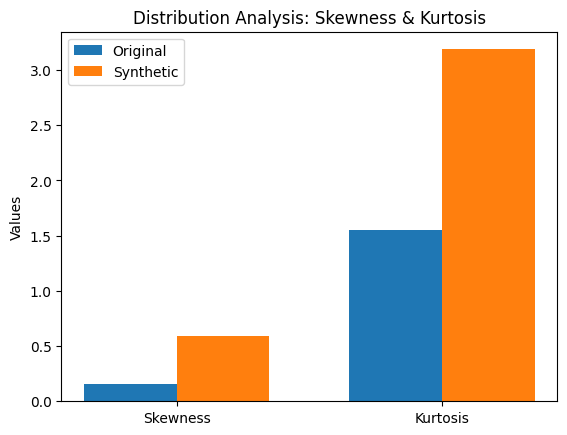

In [82]:
#Distributional Analysis
import scipy.stats as stats

# Calculate daily returns
original_returns = aligned_stock_data.pct_change().dropna()
synthetic_returns = aligned_rescaled_synthetic_data_volatile.pct_change().dropna()

# K-S Test
ks_statistic, ks_pvalue = stats.ks_2samp(original_returns, synthetic_returns)

# Skewness and Kurtosis
original_skewness = stats.skew(original_returns)
synthetic_skewness = stats.skew(synthetic_returns)

original_kurtosis = stats.kurtosis(original_returns)
synthetic_kurtosis = stats.kurtosis(synthetic_returns)

# Print Results
print(f"K-S Statistic: {ks_statistic}")
print(f"K-S P-value: {ks_pvalue}")

print("\nMetrics\t\tOriginal\tSynthetic")
print(f"Skewness:\t{original_skewness:.2f}\t\t{synthetic_skewness:.2f}")
print(f"Kurtosis:\t{original_kurtosis:.2f}\t\t{synthetic_kurtosis:.2f}")

# Visualization
labels = ['Skewness', 'Kurtosis']
original_metrics = [original_skewness, original_kurtosis]
synthetic_metrics = [synthetic_skewness, synthetic_kurtosis]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_metrics, width, label='Original')
rects2 = ax.bar(x + width/2, synthetic_metrics, width, label='Synthetic')

ax.set_ylabel('Values')
ax.set_title('Distribution Analysis: Skewness & Kurtosis')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

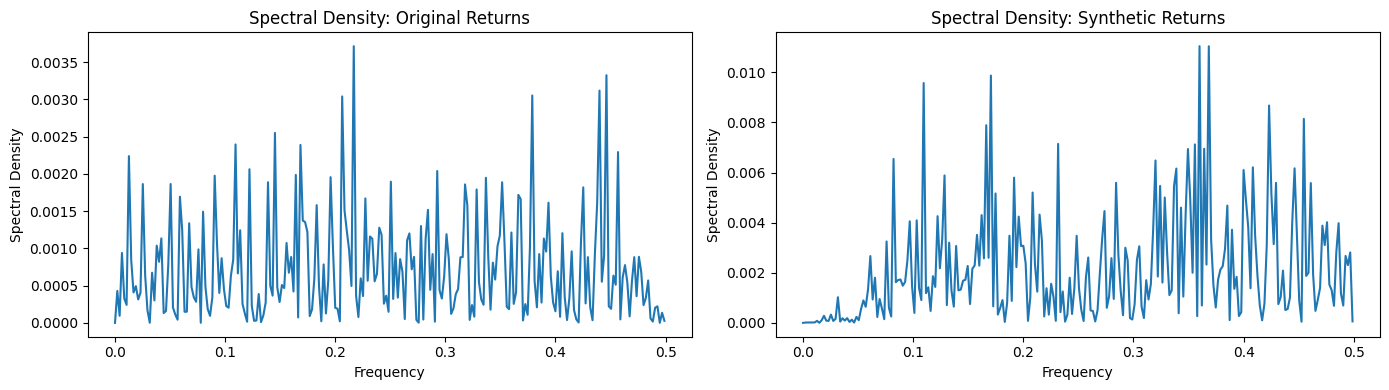

Original Returns - Spectral Density Statistics:
Max: 0.01104
Min: 0.00000
Mean: 0.00217
Standard Deviation: 0.00218


In [83]:
#Spectral Analysis
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import periodogram

# Compute daily returns
original_returns = aligned_stock_data.pct_change().dropna()
synthetic_returns = aligned_rescaled_synthetic_data_volatile.pct_change().dropna()

# Spectral Analysis
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Spectral Analysis - Original
f, Pxx = periodogram(original_returns)
axs[0].plot(f, Pxx)
axs[0].set_title('Spectral Density: Original Returns')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Spectral Density')

# Spectral Analysis - Synthetic
f, Pxx = periodogram(synthetic_returns)
axs[1].plot(f, Pxx)
axs[1].set_title('Spectral Density: Synthetic Returns')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Density')

plt.tight_layout()
plt.show()


print("Original Returns - Spectral Density Statistics:")
print(f"Max: {np.max(Pxx):.5f}")
print(f"Min: {np.min(Pxx):.5f}")
print(f"Mean: {np.mean(Pxx):.5f}")
print(f"Standard Deviation: {np.std(Pxx):.5f}")
